## **This notebook aims to combine multiple assets databases**

In [1]:
import pandas as pd
import numpy as np
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v3"
os.chdir(project_dir)

clean_data_dir = os.path.join(project_dir, "00_data/clean")
horizontal_data_dir = os.path.join(project_dir, "00_data/horizontal_structure")
results_dir = os.path.join(project_dir, "02_results")
plots_dir = os.path.join(project_dir, "03_plots")
pca_data_dir = os.path.join(project_dir, "00_data/pca")

### **GRU Model**

In [3]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        # return self.sigmoid(out)
        return out

### **LSTM Model**

In [4]:
class StockPriceLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super(StockPriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
    
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size dynamically

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # (num_layers, batch_size, hidden_dim)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :]) 
        # out = self.sigmoid(out)
        return out
    

### **Set folders**

In [5]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
thresholds = [0.5]
learning_rates = [0.005, 0.008, 0.009, 0.01]
learning_rates = [0.01]
num_epochs_list = [100, 200]
num_epochs_list = [100]
batch_sizes = [16, 32]
batch_sizes = [32]

#### **Model and Hyperparameters**

#### **Last data modifications**

In [6]:
def reshape_remove_characters(df):

    X = np.array([np.stack(row) for row in df.drop(columns=['Target']).values])
    y = df['Target'].values

    smote = SMOTE(random_state=42)
    n_samples, timesteps, n_features = X.shape
    X_flat = X.reshape((n_samples, timesteps * n_features))
    X_flat = np.where(X_flat == 'ç', 0, X_flat)

    X_resampled = X_flat.reshape((-1, timesteps, n_features))
    
    return X_resampled, y

### **Evaluation function**

In [7]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

def evaluate_model_plot(
    model, 
    X, 
    y, 
    criterion, 
    optimizer, 
    device, 
    train_size, 
    batch_size, 
    num_epochs, 
    lower_threshold,
    plots_dir=None,
    plot_filename=None
):

    # -------------------------------
    # 0) Prepare Tensors & Splits
    # -------------------------------
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    total_size = len(X)
    # Determine actual train_size index
    if train_size < 1.0:
        lower_bound = int(train_size * total_size)
    else:
        lower_bound = train_size

    # Training portion
    X_train = X[:lower_bound].to(device)
    y_train = y[:lower_bound].to(device)

    train_dataset = TensorDataset(X_train, y_train)
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,   # Set True if you prefer shuffling
        drop_last=False
    )

    if lower_bound < total_size:
        X_val = X[lower_bound:].to(device)
        y_val = y[lower_bound:].to(device)
        val_dataset = TensorDataset(X_val, y_val)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        # If there's no leftover data for "test", handle gracefully
        X_val = None
        y_val = None
        valloader = None

    # ---------------------------------------------
    # 1) SINGLE TRAINING PHASE + Track Loss Curves
    # ---------------------------------------------
    model.to(device)
    model.train()

    epoch_train_losses = []
    epoch_test_losses = []

    for epoch in range(num_epochs):
        # TRAINING PASS
        epoch_loss = 0.0
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()

            # Forward
            pred_y = model(X_batch)
            loss = criterion(pred_y, y_batch)

            # Backprop & update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # optional
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(trainloader)
        epoch_train_losses.append(avg_train_loss)

        
        # VALIDATION PASS (Optional but needed to get test_loss_curve)
        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for Xb, yb in valloader:
                    pred_yb = model(Xb)
                    loss_b = criterion(pred_yb, yb)
                    val_loss += loss_b.item()
            avg_val_loss = val_loss / len(valloader)
            epoch_test_losses.append(avg_val_loss)

            model.train()  # Switch back to train mode

        else:
            # If no validation set, just store None or 0
            epoch_test_losses.append(None)

        # Print progress every 5 epochs or last epoch
        if (epoch + 1) % 5 == 0 or (epoch == num_epochs - 1):
            if epoch_test_losses[-1] is not None:
                print(f"[Epoch {epoch+1}/{num_epochs}] ",
                      f"Train Loss: {avg_train_loss:.4f}")
            else:
                print(f"[Epoch {epoch+1}/{num_epochs}] "
                      f"Train Loss: {avg_train_loss:.4f}")

    # % decrease from first to last train loss
    if len(epoch_train_losses) > 1:
        loss_decrease_percentage = ((epoch_train_losses[-1] - epoch_train_losses[0])
                                    / epoch_train_losses[0]) * 100
    else:
        loss_decrease_percentage = 0.0

    final_train_loss = epoch_train_losses[-1]

    # -------------------------------
    # 2) ROLLING PREDICTIONS, NO UPDATE
    # -------------------------------
    model.eval()
    rolling_predictions = []
    rolling_targets = []

    for i in range(lower_bound, total_size):
        X_test = X[i:i+1].to(device)
        y_test = y[i:i+1].to(device)

        with torch.no_grad():
            pred_y = model(X_test)
            probabilities = torch.softmax(pred_y, dim=1).cpu().numpy()
            prob_class_1 = probabilities[:, 1]  # shape: (1,)

            # Threshold-based logic
            pred_classes = np.zeros_like(prob_class_1)
            # Predict -1 if prob < lower_threshold
            pred_classes[prob_class_1 < lower_threshold] = -1
            # Predict +1 if prob > (1 - lower_threshold)
            pred_classes[prob_class_1 > (1 - lower_threshold)] = 1

        rolling_predictions.append(pred_classes[0])
        rolling_targets.append(y_test.item())

    rolling_predictions = np.array(rolling_predictions)
    rolling_targets = np.array(rolling_targets).astype(int)

    # If original labels might be {0,1}, adapt as needed
    rolling_targets[rolling_targets == 0] = -1

    # Filter out zero predictions
    nonzero_mask = (rolling_predictions != 0)
    filtered_preds = rolling_predictions[nonzero_mask]
    filtered_targets = rolling_targets[nonzero_mask]

    if len(filtered_preds) == 0:
        accuracy_nonzero = None
        print("No nonzero predictions, cannot compute thresholded accuracy.")
    else:
        accuracy_nonzero = accuracy_score(filtered_targets, filtered_preds)
        print(f"Accuracy on Nonzero Predictions: {accuracy_nonzero:.4f}")

    # -------------------------------------------------
    # 3) PLOT (if plots_dir is set and there's test data)
    # -------------------------------------------------
    if plots_dir is not None:
        os.makedirs(plots_dir, exist_ok=True)

        # If user didn't provide a filename, create a default
        if plot_filename is None:
            plot_filename = "train_test_loss_curve.png"
        plot_path = os.path.join(plots_dir, plot_filename)

        # Plot the training and validation (test) loss curves
        plt.figure(figsize=(8, 5))
        plt.plot(epoch_train_losses, label="Train Loss")
        # Only plot test loss if it isn't None
        if any(x is not None for x in epoch_test_losses):
            plt.plot(epoch_test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Train vs. Test Loss per Epoch")
        plt.legend()
        plt.tight_layout()

        # plt.savefig(plot_path)
        plt.show()
        print(f"Loss curves saved to: {plot_path}")

    # ----------------
    # 4) Return results
    # ----------------
    return {
        "rolling_predictions": rolling_predictions,
        "rolling_targets": rolling_targets,
        "filtered_predictions": filtered_preds,
        "filtered_targets": filtered_targets,
        "accuracy_nonzero": accuracy_nonzero,
        "loss_decrease_percentage": loss_decrease_percentage,
        "final_train_loss": final_train_loss,
        "train_loss_curve": epoch_train_losses,
        "test_loss_curve": epoch_test_losses
    }


### **Execute evaluation funcion**

In [8]:
def combine_stocks_pkl_df(processing, security_type, period, window_size, project_dir, stocks):

    X_list = []
    y_list = []

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined
    

In [9]:
def combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size):

    X_list = []
    y_list = []
    last_stock = stocks[-1]

    for stock in stocks:
        initial_data_dir = os.path.join(project_dir, f"00_data/{processing}") 

        # 1) Load original data (info only)
        filename = f"{security_type}/{stock}/{period}_data.csv"
        original_input_filepath = os.path.join(initial_data_dir, filename)
        original_data = pd.read_csv(original_input_filepath)

        print(f"----- Appending stock: {stock}, period: {period}, data_type: {security_type} -----")

        # 2) Load the preprocessed data
        pkl_filename = f"{processing}/{security_type}/{stock}/{period}_{window_size}_data.pkl"
        input_filepath = os.path.join(horizontal_data_dir, pkl_filename)
        input_df = pd.read_pickle(input_filepath)

        # 3) Reshape
        X_resampled, y_resampled = reshape_remove_characters(input_df)
        
        # 4) Remove last rows only if not last stock
        if stock!= last_stock:
            X_resampled = X_resampled[:-test_size]
            y_resampled = y_resampled[:-test_size]

        # Store in lists
        X_list.append(X_resampled)
        y_list.append(y_resampled)

    # Concatenate all stocks along the sample dimension
    X_combined = np.concatenate(X_list, axis=0)  # Shape: (total_samples, num_features, window_size)
    y_combined = np.concatenate(y_list, axis=0)  # Shape: (total_samples,)

    # Print shapes to verify
    print("Final X shape:", X_combined.shape)
    print("Final y shape:", y_combined.shape)
    
    return X_combined, y_combined

## **Apply concatenation to specified datasets**

In [10]:
processing = "clean"
security_type = "single_name"
period = "10y"

## **Run LSTM and GRU Models**

In [11]:
possible_train_size = 95

num_epochs = 100
prediction_threshold = 0.5

learning_rate = 0.01
model_type = "gru"

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 64
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2

criterion = nn.CrossEntropyLoss()

----- Appending stock: AAPL, period: 10y, data_type: single_name -----
----- Appending stock: MSFT, period: 10y, data_type: single_name -----
----- Appending stock: AMZN, period: 10y, data_type: single_name -----
----- Appending stock: NVDA, period: 10y, data_type: single_name -----
----- Appending stock: SPX, period: 10y, data_type: single_name -----
Final X shape: (11830, 1, 5)
Final y shape: (11830,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6934
[Epoch 10/100]  Train Loss: 0.6919
[Epoch 15/100]  Train Loss: 0.6906
[Epoch 20/100]  Train Loss: 0.6893
[Epoch 25/100]  Train Loss: 0.6877
[Epoch 30/100]  Train Loss: 0.6859
[Epoch 35/100]  Train Loss: 0.6846
[Epoch 40/100]  Train Loss: 0.6834
[Epoch 45/100]  Train Loss: 0.6816
[Epoch 50/100]  Train Loss: 0.6802
[Epoch 55/100]  Train Loss: 0.6791
[Epoch 60/100]  Train Loss: 0.6779
[Epoch 65/100]  Train Loss: 0.6766
[Epoch 70/100]  Train Loss: 0.6753
[Epoch 75/100]  Train Los

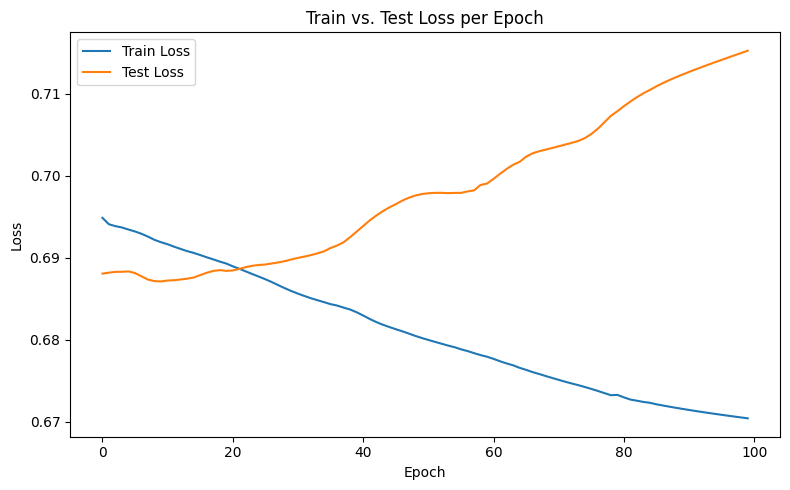

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6932
[Epoch 10/100]  Train Loss: 0.6923
[Epoch 15/100]  Train Loss: 0.6914
[Epoch 20/100]  Train Loss: 0.6903
[Epoch 25/100]  Train Loss: 0.6889
[Epoch 30/100]  Train Loss: 0.6874
[Epoch 35/100]  Train Loss: 0.6860
[Epoch 40/100]  Train Loss: 0.6848
[Epoch 45/100]  Train Loss: 0.6834
[Epoch 50/100]  Train Loss: 0.6818
[Epoch 55/100]  Train Loss: 0.6801
[Epoch 60/100]  Train Loss: 0.6785
[Epoch 65/100]  Train Loss: 0.6770
[Epoch 70/100]  Train Loss: 0.6757
[Epoch 75/100]  Train Loss: 0.6748
[Epoch 80/100]  Train Loss: 0.6738
[Epoch 85/100]  Train Loss: 0.6729
[Epoch 90/100]  Train Loss: 0.6720
[Epoch 95/100]  Train Loss: 0.6713
[Epoch 100/100]  Train Loss: 0.6705
Accuracy on Nonzero Predictions: 0.5033


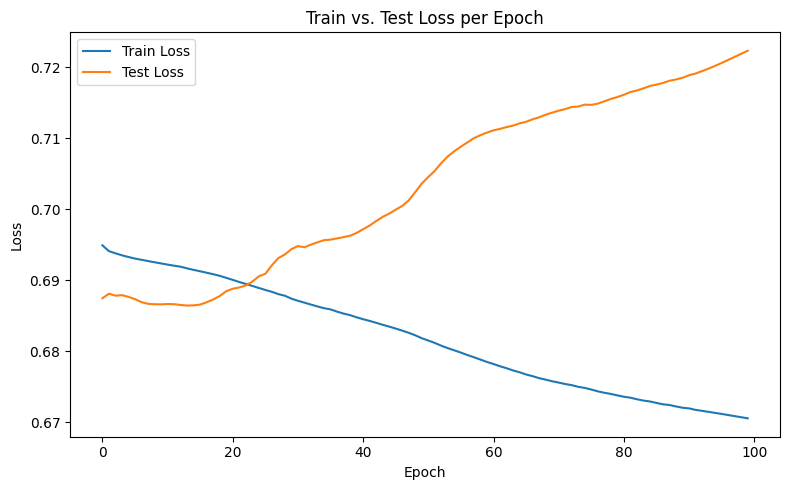

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6933
[Epoch 10/100]  Train Loss: 0.6918
[Epoch 15/100]  Train Loss: 0.6907
[Epoch 20/100]  Train Loss: 0.6895
[Epoch 25/100]  Train Loss: 0.6878
[Epoch 30/100]  Train Loss: 0.6866
[Epoch 35/100]  Train Loss: 0.6856
[Epoch 40/100]  Train Loss: 0.6839
[Epoch 45/100]  Train Loss: 0.6823
[Epoch 50/100]  Train Loss: 0.6802
[Epoch 55/100]  Train Loss: 0.6786
[Epoch 60/100]  Train Loss: 0.6769
[Epoch 65/100]  Train Loss: 0.6747
[Epoch 70/100]  Train Loss: 0.6728
[Epoch 75/100]  Train Loss: 0.6712
[Epoch 80/100]  Train Loss: 0.6695
[Epoch 85/100]  Train Loss: 0.6681
[Epoch 90/100]  Train Loss: 0.6666
[Epoch 95/100]  Train Loss: 0.6650
[Epoch 100/100]  Train Loss: 0.6632
Accuracy on Nonzero Predictions: 0.5167


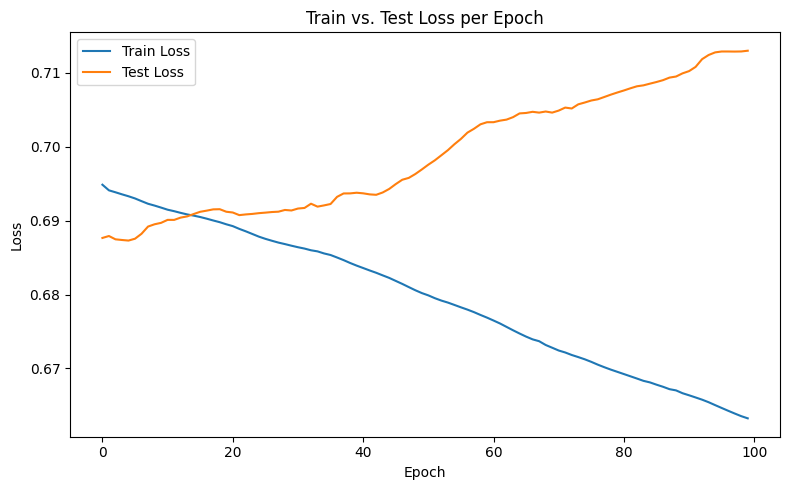

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6932
[Epoch 10/100]  Train Loss: 0.6917
[Epoch 15/100]  Train Loss: 0.6906
[Epoch 20/100]  Train Loss: 0.6887
[Epoch 25/100]  Train Loss: 0.6866
[Epoch 30/100]  Train Loss: 0.6844
[Epoch 35/100]  Train Loss: 0.6828
[Epoch 40/100]  Train Loss: 0.6812
[Epoch 45/100]  Train Loss: 0.6797
[Epoch 50/100]  Train Loss: 0.6783
[Epoch 55/100]  Train Loss: 0.6767
[Epoch 60/100]  Train Loss: 0.6755
[Epoch 65/100]  Train Loss: 0.6742
[Epoch 70/100]  Train Loss: 0.6728
[Epoch 75/100]  Train Loss: 0.6715
[Epoch 80/100]  Train Loss: 0.6702
[Epoch 85/100]  Train Loss: 0.6690
[Epoch 90/100]  Train Loss: 0.6678
[Epoch 95/100]  Train Loss: 0.6665
[Epoch 100/100]  Train Loss: 0.6653
Accuracy on Nonzero Predictions: 0.4933


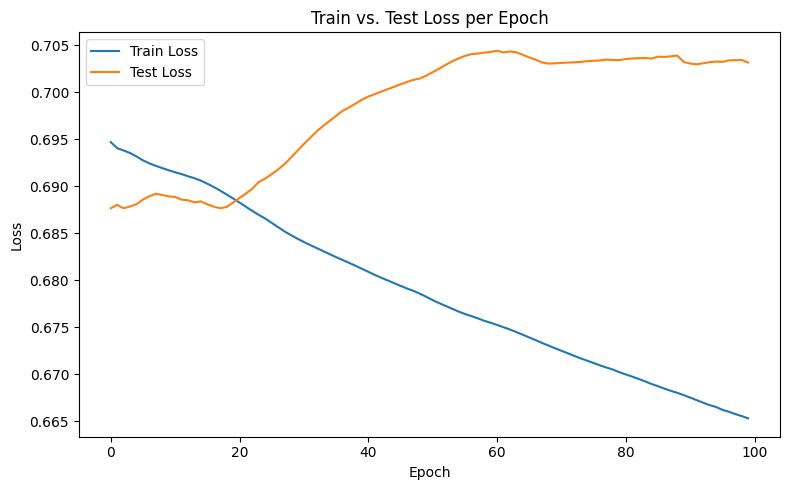

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6935
[Epoch 10/100]  Train Loss: 0.6925
[Epoch 15/100]  Train Loss: 0.6916
[Epoch 20/100]  Train Loss: 0.6903
[Epoch 25/100]  Train Loss: 0.6881
[Epoch 30/100]  Train Loss: 0.6860
[Epoch 35/100]  Train Loss: 0.6845
[Epoch 40/100]  Train Loss: 0.6835
[Epoch 45/100]  Train Loss: 0.6826
[Epoch 50/100]  Train Loss: 0.6814
[Epoch 55/100]  Train Loss: 0.6805
[Epoch 60/100]  Train Loss: 0.6792
[Epoch 65/100]  Train Loss: 0.6784
[Epoch 70/100]  Train Loss: 0.6776
[Epoch 75/100]  Train Loss: 0.6767
[Epoch 80/100]  Train Loss: 0.6759
[Epoch 85/100]  Train Loss: 0.6752
[Epoch 90/100]  Train Loss: 0.6747
[Epoch 95/100]  Train Loss: 0.6742
[Epoch 100/100]  Train Loss: 0.6735
Accuracy on Nonzero Predictions: 0.5733


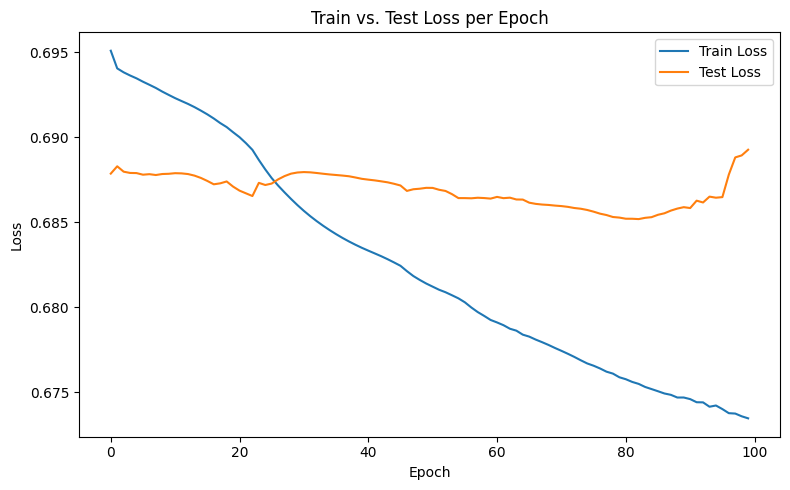

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6938
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6933
[Epoch 20/100]  Train Loss: 0.6922
[Epoch 25/100]  Train Loss: 0.6900
[Epoch 30/100]  Train Loss: 0.6892
[Epoch 35/100]  Train Loss: 0.6873
[Epoch 40/100]  Train Loss: 0.6846
[Epoch 45/100]  Train Loss: 0.6834
[Epoch 50/100]  Train Loss: 0.6795
[Epoch 55/100]  Train Loss: 0.6780
[Epoch 60/100]  Train Loss: 0.6780
[Epoch 65/100]  Train Loss: 0.6744
[Epoch 70/100]  Train Loss: 0.6720
[Epoch 75/100]  Train Loss: 0.6692
[Epoch 80/100]  Train Loss: 0.6676
[Epoch 85/100]  Train Loss: 0.6688
[Epoch 90/100]  Train Loss: 0.6647
[Epoch 95/100]  Train Loss: 0.6612
[Epoch 100/100]  Train Loss: 0.6621
Accuracy on Nonzero Predictions: 0.5467


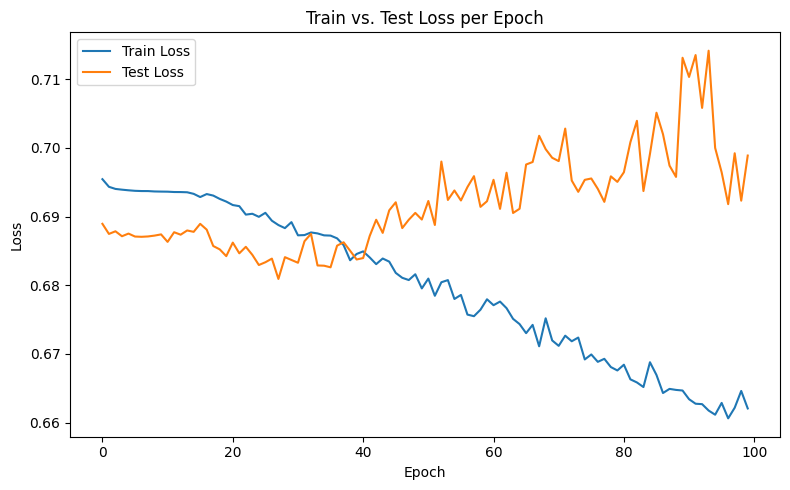

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6937
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6934
[Epoch 20/100]  Train Loss: 0.6931
[Epoch 25/100]  Train Loss: 0.6928
[Epoch 30/100]  Train Loss: 0.6918
[Epoch 35/100]  Train Loss: 0.6902
[Epoch 40/100]  Train Loss: 0.6878
[Epoch 45/100]  Train Loss: 0.6863
[Epoch 50/100]  Train Loss: 0.6829
[Epoch 55/100]  Train Loss: 0.6824
[Epoch 60/100]  Train Loss: 0.6798
[Epoch 65/100]  Train Loss: 0.6784
[Epoch 70/100]  Train Loss: 0.6760
[Epoch 75/100]  Train Loss: 0.6758
[Epoch 80/100]  Train Loss: 0.6701
[Epoch 85/100]  Train Loss: 0.6697
[Epoch 90/100]  Train Loss: 0.6705
[Epoch 95/100]  Train Loss: 0.6672
[Epoch 100/100]  Train Loss: 0.6651
Accuracy on Nonzero Predictions: 0.5300


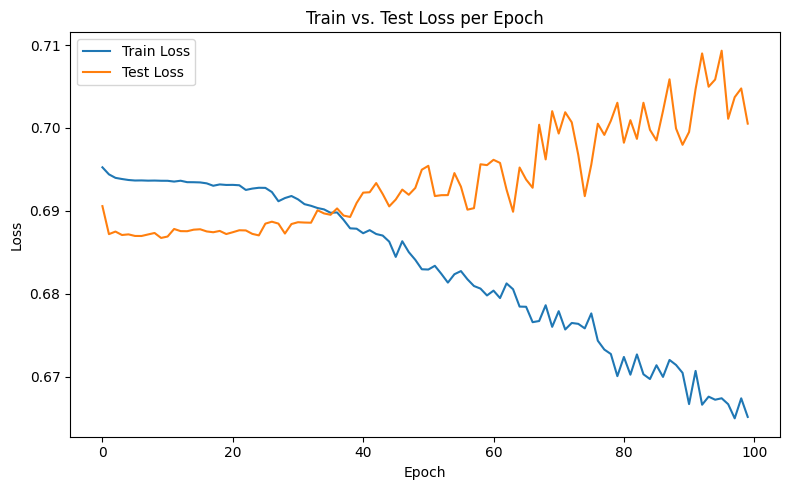

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6938
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6935
[Epoch 20/100]  Train Loss: 0.6928
[Epoch 25/100]  Train Loss: 0.6916
[Epoch 30/100]  Train Loss: 0.6900
[Epoch 35/100]  Train Loss: 0.6884
[Epoch 40/100]  Train Loss: 0.6858
[Epoch 45/100]  Train Loss: 0.6834
[Epoch 50/100]  Train Loss: 0.6813
[Epoch 55/100]  Train Loss: 0.6797
[Epoch 60/100]  Train Loss: 0.6780
[Epoch 65/100]  Train Loss: 0.6745
[Epoch 70/100]  Train Loss: 0.6727
[Epoch 75/100]  Train Loss: 0.6705
[Epoch 80/100]  Train Loss: 0.6676
[Epoch 85/100]  Train Loss: 0.6690
[Epoch 90/100]  Train Loss: 0.6655
[Epoch 95/100]  Train Loss: 0.6624
[Epoch 100/100]  Train Loss: 0.6625
Accuracy on Nonzero Predictions: 0.5433


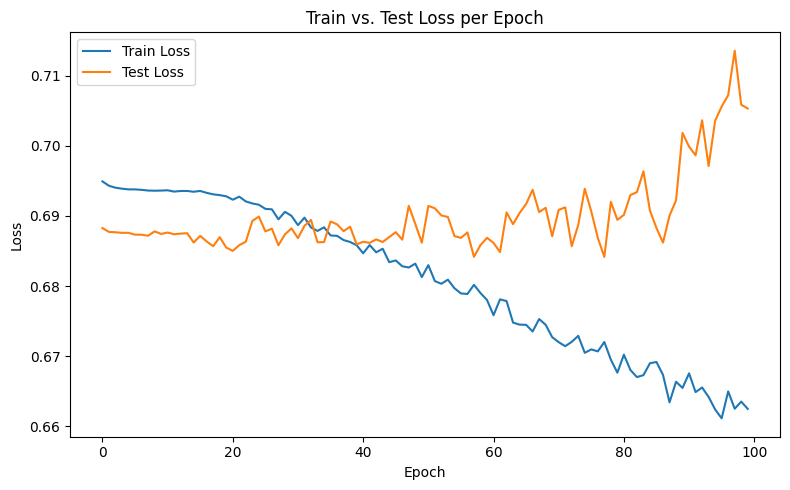

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6939
[Epoch 10/100]  Train Loss: 0.6936
[Epoch 15/100]  Train Loss: 0.6930
[Epoch 20/100]  Train Loss: 0.6918
[Epoch 25/100]  Train Loss: 0.6909
[Epoch 30/100]  Train Loss: 0.6880
[Epoch 35/100]  Train Loss: 0.6865
[Epoch 40/100]  Train Loss: 0.6852
[Epoch 45/100]  Train Loss: 0.6820
[Epoch 50/100]  Train Loss: 0.6807
[Epoch 55/100]  Train Loss: 0.6763
[Epoch 60/100]  Train Loss: 0.6730
[Epoch 65/100]  Train Loss: 0.6714
[Epoch 70/100]  Train Loss: 0.6720
[Epoch 75/100]  Train Loss: 0.6653
[Epoch 80/100]  Train Loss: 0.6641
[Epoch 85/100]  Train Loss: 0.6643
[Epoch 90/100]  Train Loss: 0.6612
[Epoch 95/100]  Train Loss: 0.6587
[Epoch 100/100]  Train Loss: 0.6565
Accuracy on Nonzero Predictions: 0.5133


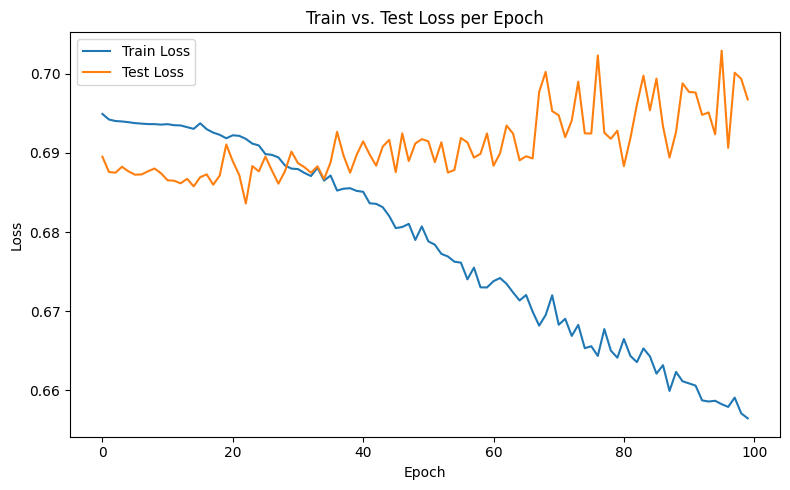

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6937
[Epoch 10/100]  Train Loss: 0.6937
[Epoch 15/100]  Train Loss: 0.6936
[Epoch 20/100]  Train Loss: 0.6935
[Epoch 25/100]  Train Loss: 0.6927
[Epoch 30/100]  Train Loss: 0.6925
[Epoch 35/100]  Train Loss: 0.6911
[Epoch 40/100]  Train Loss: 0.6891
[Epoch 45/100]  Train Loss: 0.6870
[Epoch 50/100]  Train Loss: 0.6854
[Epoch 55/100]  Train Loss: 0.6836
[Epoch 60/100]  Train Loss: 0.6810
[Epoch 65/100]  Train Loss: 0.6807
[Epoch 70/100]  Train Loss: 0.6781
[Epoch 75/100]  Train Loss: 0.6766
[Epoch 80/100]  Train Loss: 0.6726
[Epoch 85/100]  Train Loss: 0.6749
[Epoch 90/100]  Train Loss: 0.6717
[Epoch 95/100]  Train Loss: 0.6694
[Epoch 100/100]  Train Loss: 0.6712
Accuracy on Nonzero Predictions: 0.5367


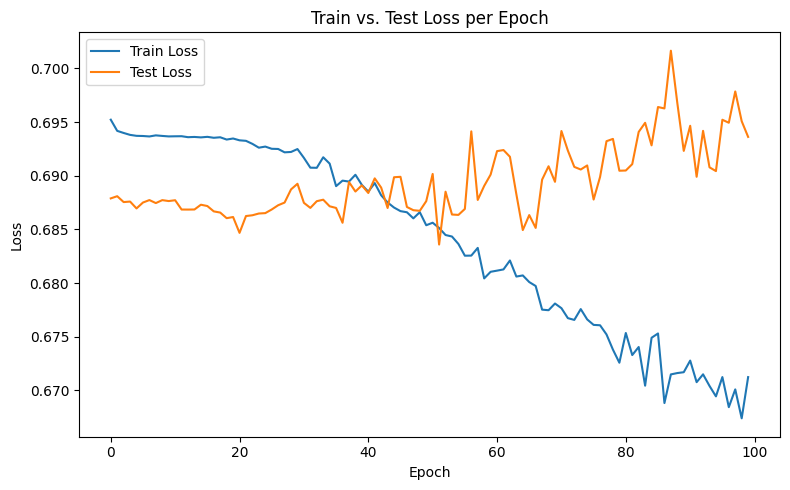

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: single_name -----
----- Appending stock: MSFT, period: 10y, data_type: single_name -----
----- Appending stock: AMZN, period: 10y, data_type: single_name -----
----- Appending stock: NVDA, period: 10y, data_type: single_name -----
----- Appending stock: SPX, period: 10y, data_type: single_name -----
Final X shape: (11805, 1, 10)
Final y shape: (11805,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6894
[Epoch 10/100]  Train Loss: 0.6738
[Epoch 15/100]  Train Loss: 0.6516
[Epoch 20/100]  Train Loss: 0.6315
[Epoch 25/100]  Train Loss: 0.6122
[Epoch 30/100]  Train Loss: 0.5949
[Epoch 35/100]  Train Loss: 0.5797
[Epoch 40/100]  Train Loss: 0.5673
[Epoch 45/100]  Train Loss: 0.5565
[Epoch 50/100]  Train Loss: 0.5471
[Epoch 55/100]  Train Loss: 0.5390
[Epoch 60/100]  Train L

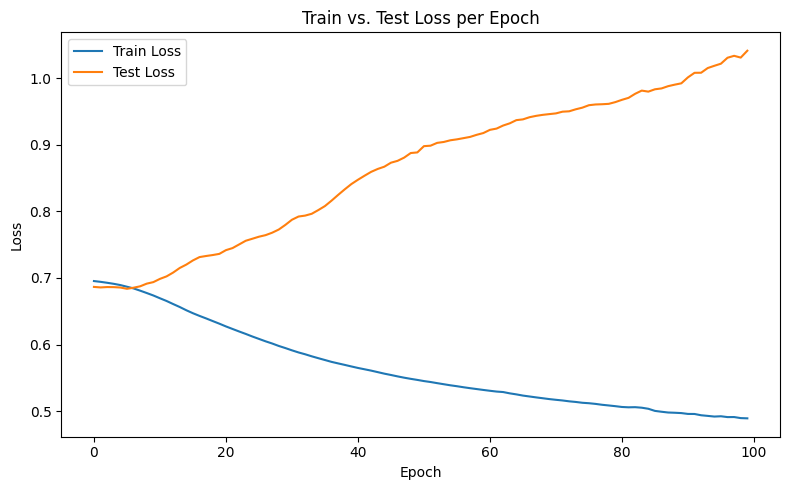

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6894
[Epoch 10/100]  Train Loss: 0.6743
[Epoch 15/100]  Train Loss: 0.6537
[Epoch 20/100]  Train Loss: 0.6344
[Epoch 25/100]  Train Loss: 0.6159
[Epoch 30/100]  Train Loss: 0.5989
[Epoch 35/100]  Train Loss: 0.5853
[Epoch 40/100]  Train Loss: 0.5720
[Epoch 45/100]  Train Loss: 0.5612
[Epoch 50/100]  Train Loss: 0.5496
[Epoch 55/100]  Train Loss: 0.5387
[Epoch 60/100]  Train Loss: 0.5280
[Epoch 65/100]  Train Loss: 0.5200
[Epoch 70/100]  Train Loss: 0.5131
[Epoch 75/100]  Train Loss: 0.5068
[Epoch 80/100]  Train Loss: 0.5027
[Epoch 85/100]  Train Loss: 0.4972
[Epoch 90/100]  Train Loss: 0.4932
[Epoch 95/100]  Train Loss: 0.4886
[Epoch 100/100]  Train Loss: 0.4854
Accuracy on Nonzero Predictions: 0.5200


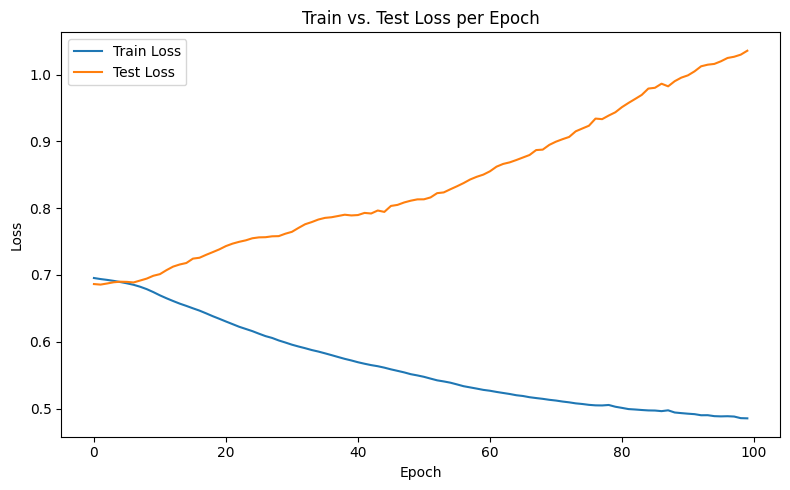

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6888
[Epoch 10/100]  Train Loss: 0.6739
[Epoch 15/100]  Train Loss: 0.6537
[Epoch 20/100]  Train Loss: 0.6335
[Epoch 25/100]  Train Loss: 0.6180
[Epoch 30/100]  Train Loss: 0.6046
[Epoch 35/100]  Train Loss: 0.5912
[Epoch 40/100]  Train Loss: 0.5801
[Epoch 45/100]  Train Loss: 0.5692
[Epoch 50/100]  Train Loss: 0.5584
[Epoch 55/100]  Train Loss: 0.5499
[Epoch 60/100]  Train Loss: 0.5408
[Epoch 65/100]  Train Loss: 0.5333
[Epoch 70/100]  Train Loss: 0.5261
[Epoch 75/100]  Train Loss: 0.5192
[Epoch 80/100]  Train Loss: 0.5139
[Epoch 85/100]  Train Loss: 0.5089
[Epoch 90/100]  Train Loss: 0.5048
[Epoch 95/100]  Train Loss: 0.5026
[Epoch 100/100]  Train Loss: 0.4980
Accuracy on Nonzero Predictions: 0.4900


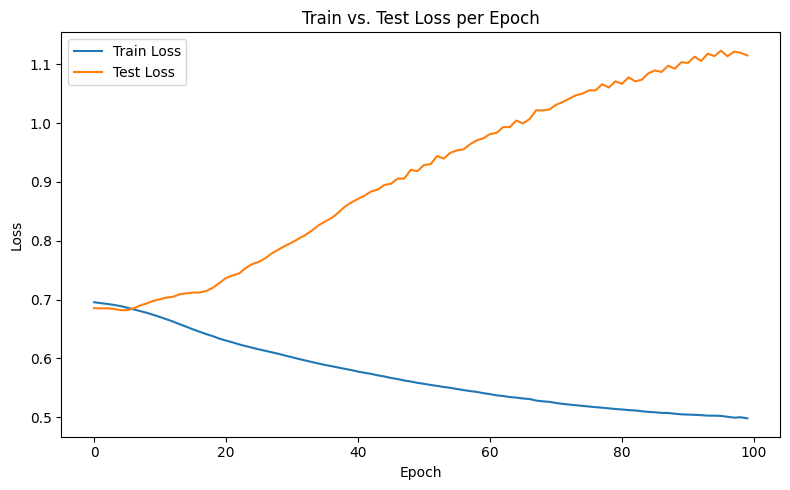

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6887
[Epoch 10/100]  Train Loss: 0.6731
[Epoch 15/100]  Train Loss: 0.6540
[Epoch 20/100]  Train Loss: 0.6360
[Epoch 25/100]  Train Loss: 0.6179
[Epoch 30/100]  Train Loss: 0.5985
[Epoch 35/100]  Train Loss: 0.5810
[Epoch 40/100]  Train Loss: 0.5679
[Epoch 45/100]  Train Loss: 0.5569
[Epoch 50/100]  Train Loss: 0.5472
[Epoch 55/100]  Train Loss: 0.5378
[Epoch 60/100]  Train Loss: 0.5282
[Epoch 65/100]  Train Loss: 0.5209
[Epoch 70/100]  Train Loss: 0.5156
[Epoch 75/100]  Train Loss: 0.5103
[Epoch 80/100]  Train Loss: 0.5060
[Epoch 85/100]  Train Loss: 0.5024
[Epoch 90/100]  Train Loss: 0.4980
[Epoch 95/100]  Train Loss: 0.4937
[Epoch 100/100]  Train Loss: 0.4917
Accuracy on Nonzero Predictions: 0.5100


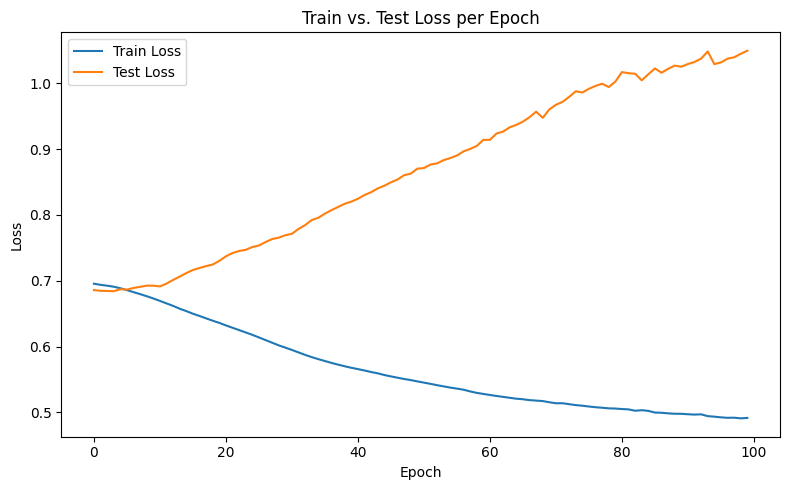

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6886
[Epoch 10/100]  Train Loss: 0.6728
[Epoch 15/100]  Train Loss: 0.6586
[Epoch 20/100]  Train Loss: 0.6440
[Epoch 25/100]  Train Loss: 0.6282
[Epoch 30/100]  Train Loss: 0.6117
[Epoch 35/100]  Train Loss: 0.5955
[Epoch 40/100]  Train Loss: 0.5774
[Epoch 45/100]  Train Loss: 0.5613
[Epoch 50/100]  Train Loss: 0.5468
[Epoch 55/100]  Train Loss: 0.5361
[Epoch 60/100]  Train Loss: 0.5269
[Epoch 65/100]  Train Loss: 0.5189
[Epoch 70/100]  Train Loss: 0.5128
[Epoch 75/100]  Train Loss: 0.5057
[Epoch 80/100]  Train Loss: 0.5015
[Epoch 85/100]  Train Loss: 0.4952
[Epoch 90/100]  Train Loss: 0.4917
[Epoch 95/100]  Train Loss: 0.4898
[Epoch 100/100]  Train Loss: 0.4853
Accuracy on Nonzero Predictions: 0.5167


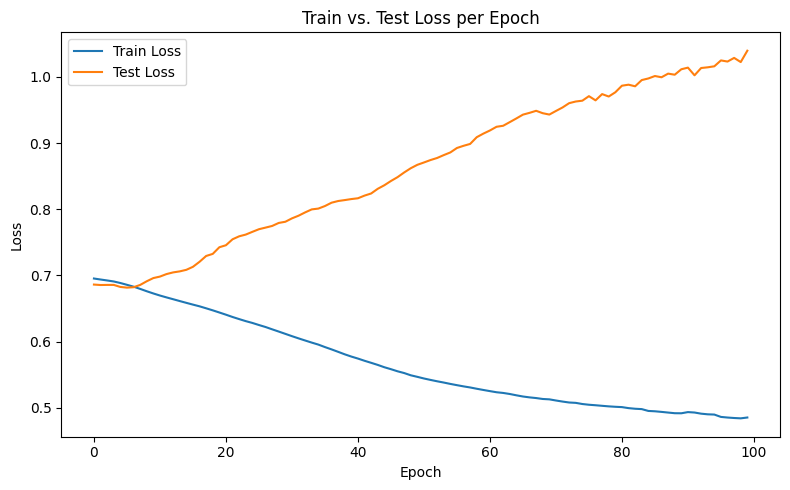

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6932
[Epoch 10/100]  Train Loss: 0.6890
[Epoch 15/100]  Train Loss: 0.6763
[Epoch 20/100]  Train Loss: 0.6651
[Epoch 25/100]  Train Loss: 0.6505
[Epoch 30/100]  Train Loss: 0.6388
[Epoch 35/100]  Train Loss: 0.6267
[Epoch 40/100]  Train Loss: 0.6095
[Epoch 45/100]  Train Loss: 0.6070
[Epoch 50/100]  Train Loss: 0.5900
[Epoch 55/100]  Train Loss: 0.5810
[Epoch 60/100]  Train Loss: 0.5779
[Epoch 65/100]  Train Loss: 0.5651
[Epoch 70/100]  Train Loss: 0.5657
[Epoch 75/100]  Train Loss: 0.5547
[Epoch 80/100]  Train Loss: 0.5514
[Epoch 85/100]  Train Loss: 0.5541
[Epoch 90/100]  Train Loss: 0.5527
[Epoch 95/100]  Train Loss: 0.5393
[Epoch 100/100]  Train Loss: 0.5390
Accuracy on Nonzero Predictions: 0.5067


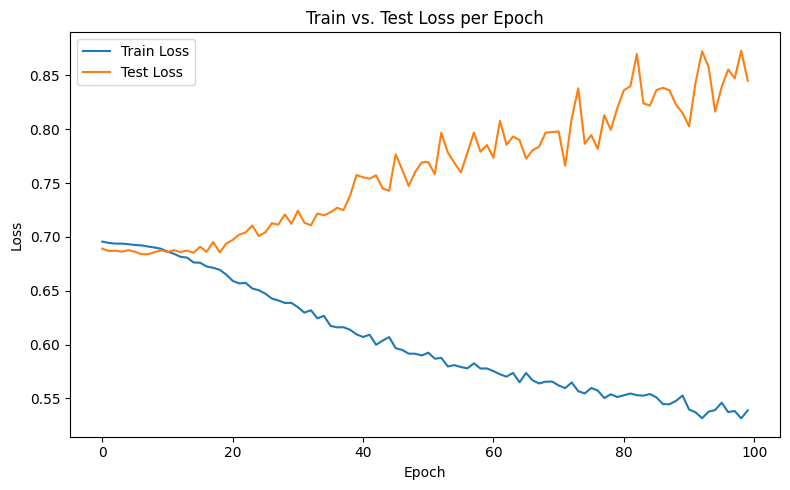

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6925
[Epoch 10/100]  Train Loss: 0.6854
[Epoch 15/100]  Train Loss: 0.6679
[Epoch 20/100]  Train Loss: 0.6518
[Epoch 25/100]  Train Loss: 0.6336
[Epoch 30/100]  Train Loss: 0.6135
[Epoch 35/100]  Train Loss: 0.6023
[Epoch 40/100]  Train Loss: 0.5907
[Epoch 45/100]  Train Loss: 0.5777
[Epoch 50/100]  Train Loss: 0.5717
[Epoch 55/100]  Train Loss: 0.5571
[Epoch 60/100]  Train Loss: 0.5588
[Epoch 65/100]  Train Loss: 0.5512
[Epoch 70/100]  Train Loss: 0.5476
[Epoch 75/100]  Train Loss: 0.5412
[Epoch 80/100]  Train Loss: 0.5341
[Epoch 85/100]  Train Loss: 0.5327
[Epoch 90/100]  Train Loss: 0.5230
[Epoch 95/100]  Train Loss: 0.5273
[Epoch 100/100]  Train Loss: 0.5254
Accuracy on Nonzero Predictions: 0.5100


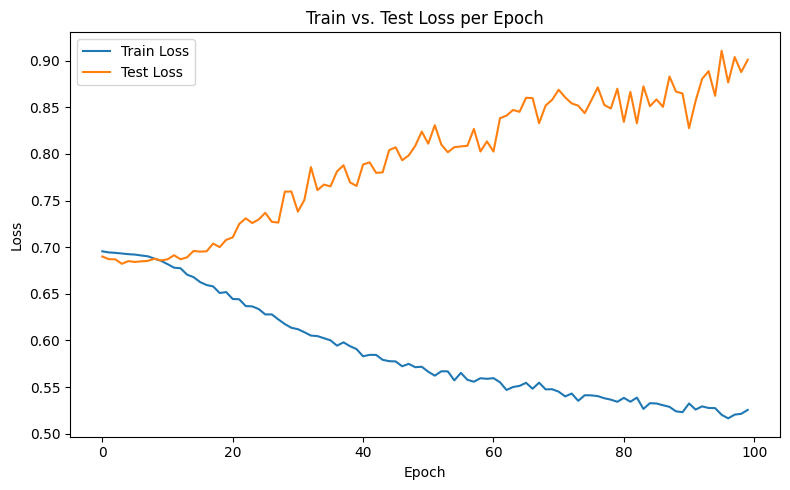

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6935
[Epoch 10/100]  Train Loss: 0.6892
[Epoch 15/100]  Train Loss: 0.6789
[Epoch 20/100]  Train Loss: 0.6664
[Epoch 25/100]  Train Loss: 0.6529
[Epoch 30/100]  Train Loss: 0.6349
[Epoch 35/100]  Train Loss: 0.6274
[Epoch 40/100]  Train Loss: 0.6147
[Epoch 45/100]  Train Loss: 0.5996
[Epoch 50/100]  Train Loss: 0.5916
[Epoch 55/100]  Train Loss: 0.5888
[Epoch 60/100]  Train Loss: 0.5785
[Epoch 65/100]  Train Loss: 0.5718
[Epoch 70/100]  Train Loss: 0.5645
[Epoch 75/100]  Train Loss: 0.5655
[Epoch 80/100]  Train Loss: 0.5554
[Epoch 85/100]  Train Loss: 0.5584
[Epoch 90/100]  Train Loss: 0.5474
[Epoch 95/100]  Train Loss: 0.5453
[Epoch 100/100]  Train Loss: 0.5410
Accuracy on Nonzero Predictions: 0.4967


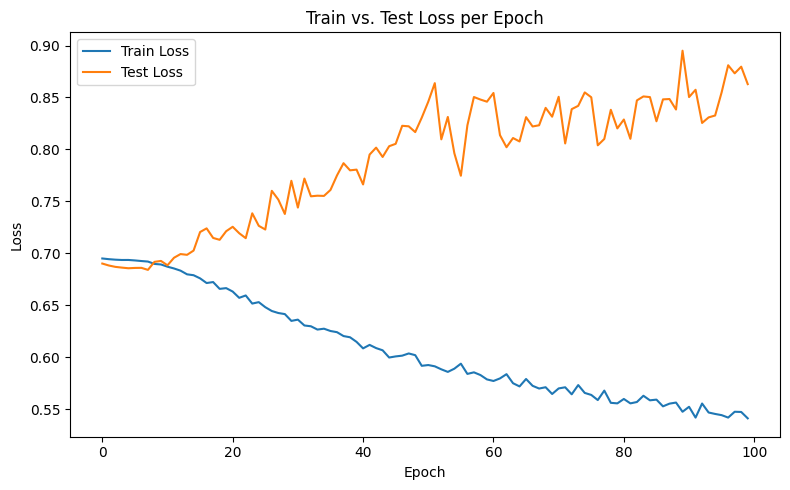

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6935
[Epoch 10/100]  Train Loss: 0.6892
[Epoch 15/100]  Train Loss: 0.6802
[Epoch 20/100]  Train Loss: 0.6661
[Epoch 25/100]  Train Loss: 0.6496
[Epoch 30/100]  Train Loss: 0.6348
[Epoch 35/100]  Train Loss: 0.6216
[Epoch 40/100]  Train Loss: 0.6136
[Epoch 45/100]  Train Loss: 0.6022
[Epoch 50/100]  Train Loss: 0.5900
[Epoch 55/100]  Train Loss: 0.5861
[Epoch 60/100]  Train Loss: 0.5745
[Epoch 65/100]  Train Loss: 0.5769
[Epoch 70/100]  Train Loss: 0.5636
[Epoch 75/100]  Train Loss: 0.5637
[Epoch 80/100]  Train Loss: 0.5524
[Epoch 85/100]  Train Loss: 0.5480
[Epoch 90/100]  Train Loss: 0.5488
[Epoch 95/100]  Train Loss: 0.5458
[Epoch 100/100]  Train Loss: 0.5423
Accuracy on Nonzero Predictions: 0.5100


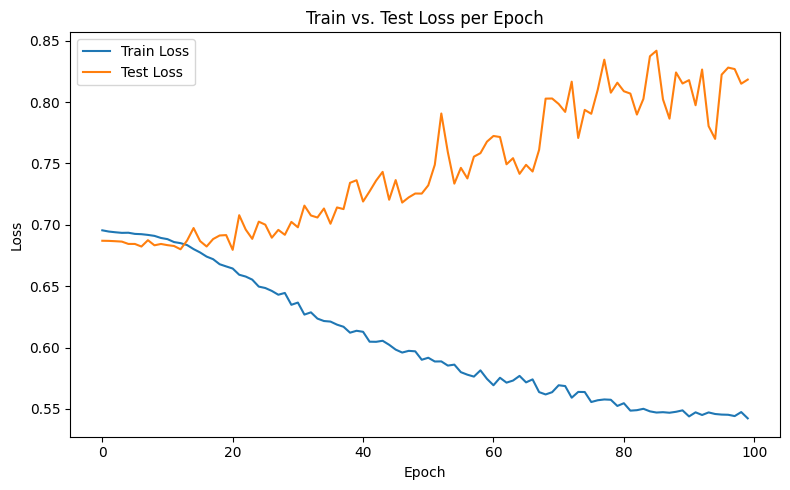

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6934
[Epoch 10/100]  Train Loss: 0.6876
[Epoch 15/100]  Train Loss: 0.6789
[Epoch 20/100]  Train Loss: 0.6660
[Epoch 25/100]  Train Loss: 0.6549
[Epoch 30/100]  Train Loss: 0.6357
[Epoch 35/100]  Train Loss: 0.6220
[Epoch 40/100]  Train Loss: 0.6051
[Epoch 45/100]  Train Loss: 0.6014
[Epoch 50/100]  Train Loss: 0.5901
[Epoch 55/100]  Train Loss: 0.5720
[Epoch 60/100]  Train Loss: 0.5735
[Epoch 65/100]  Train Loss: 0.5658
[Epoch 70/100]  Train Loss: 0.5600
[Epoch 75/100]  Train Loss: 0.5466
[Epoch 80/100]  Train Loss: 0.5487
[Epoch 85/100]  Train Loss: 0.5372
[Epoch 90/100]  Train Loss: 0.5422
[Epoch 95/100]  Train Loss: 0.5297
[Epoch 100/100]  Train Loss: 0.5326
Accuracy on Nonzero Predictions: 0.5167


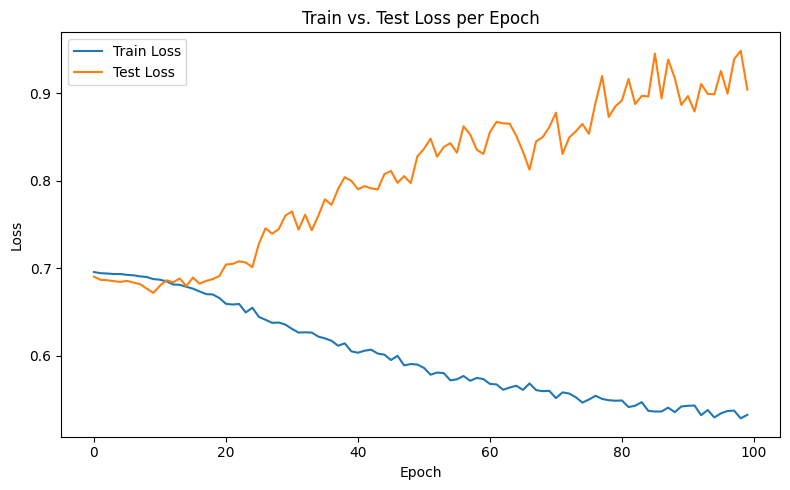

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: single_name -----
----- Appending stock: MSFT, period: 10y, data_type: single_name -----
----- Appending stock: AMZN, period: 10y, data_type: single_name -----
----- Appending stock: NVDA, period: 10y, data_type: single_name -----
----- Appending stock: SPX, period: 10y, data_type: single_name -----
Final X shape: (11605, 1, 50)
Final y shape: (11605,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4827
[Epoch 10/100]  Train Loss: 0.2095
[Epoch 15/100]  Train Loss: 0.1067
[Epoch 20/100]  Train Loss: 0.0627
[Epoch 25/100]  Train Loss: 0.0061
[Epoch 30/100]  Train Loss: 0.0027
[Epoch 35/100]  Train Loss: 0.0015
[Epoch 40/100]  Train Loss: 0.0009
[Epoch 45/100]  Train Loss: 0.0005
[Epoch 50/100]  Train Loss: 0.0003
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train L

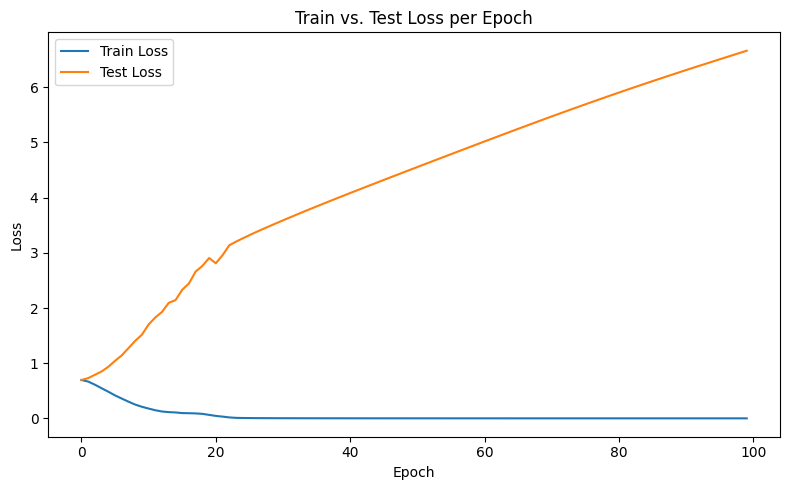

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4865
[Epoch 10/100]  Train Loss: 0.1948
[Epoch 15/100]  Train Loss: 0.0971
[Epoch 20/100]  Train Loss: 0.0864
[Epoch 25/100]  Train Loss: 0.0138
[Epoch 30/100]  Train Loss: 0.0029
[Epoch 35/100]  Train Loss: 0.0016
[Epoch 40/100]  Train Loss: 0.0009
[Epoch 45/100]  Train Loss: 0.0006
[Epoch 50/100]  Train Loss: 0.0004
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0001
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4767


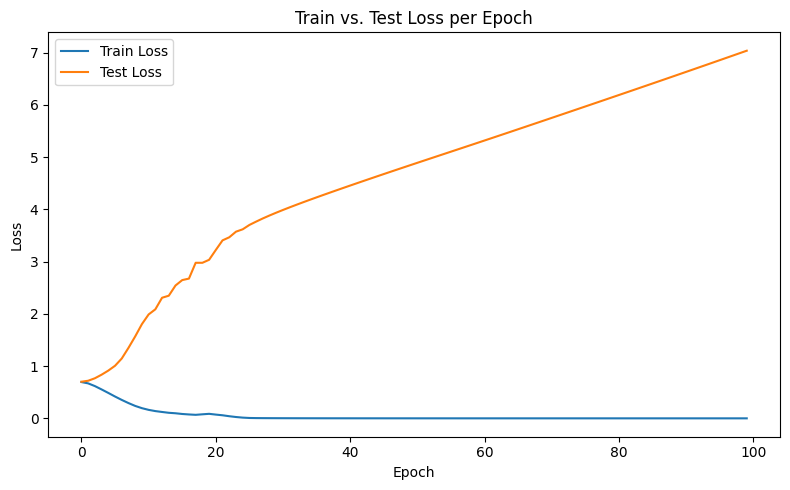

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4958
[Epoch 10/100]  Train Loss: 0.2175
[Epoch 15/100]  Train Loss: 0.1009
[Epoch 20/100]  Train Loss: 0.0680
[Epoch 25/100]  Train Loss: 0.0270
[Epoch 30/100]  Train Loss: 0.0534
[Epoch 35/100]  Train Loss: 0.0037
[Epoch 40/100]  Train Loss: 0.0019
[Epoch 45/100]  Train Loss: 0.0011
[Epoch 50/100]  Train Loss: 0.0007
[Epoch 55/100]  Train Loss: 0.0004
[Epoch 60/100]  Train Loss: 0.0003
[Epoch 65/100]  Train Loss: 0.0002
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0001
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5000


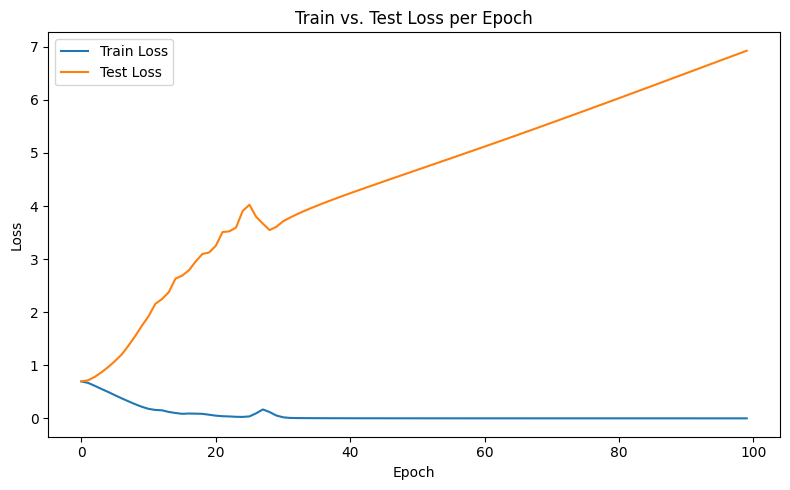

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4919
[Epoch 10/100]  Train Loss: 0.2183
[Epoch 15/100]  Train Loss: 0.1186
[Epoch 20/100]  Train Loss: 0.0479
[Epoch 25/100]  Train Loss: 0.0831
[Epoch 30/100]  Train Loss: 0.0050
[Epoch 35/100]  Train Loss: 0.0021
[Epoch 40/100]  Train Loss: 0.0012
[Epoch 45/100]  Train Loss: 0.0007
[Epoch 50/100]  Train Loss: 0.0004
[Epoch 55/100]  Train Loss: 0.0003
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5067


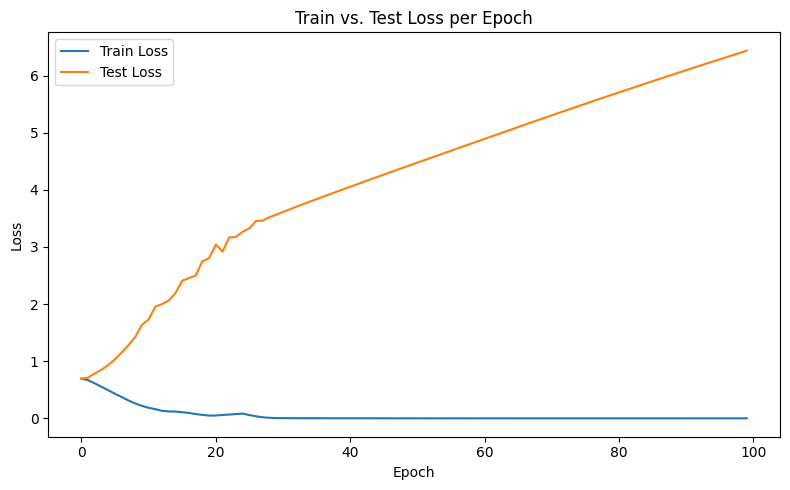

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.4908
[Epoch 10/100]  Train Loss: 0.2174
[Epoch 15/100]  Train Loss: 0.1112
[Epoch 20/100]  Train Loss: 0.0812
[Epoch 25/100]  Train Loss: 0.0168
[Epoch 30/100]  Train Loss: 0.0034
[Epoch 35/100]  Train Loss: 0.0018
[Epoch 40/100]  Train Loss: 0.0011
[Epoch 45/100]  Train Loss: 0.0006
[Epoch 50/100]  Train Loss: 0.0004
[Epoch 55/100]  Train Loss: 0.0002
[Epoch 60/100]  Train Loss: 0.0002
[Epoch 65/100]  Train Loss: 0.0001
[Epoch 70/100]  Train Loss: 0.0001
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4733


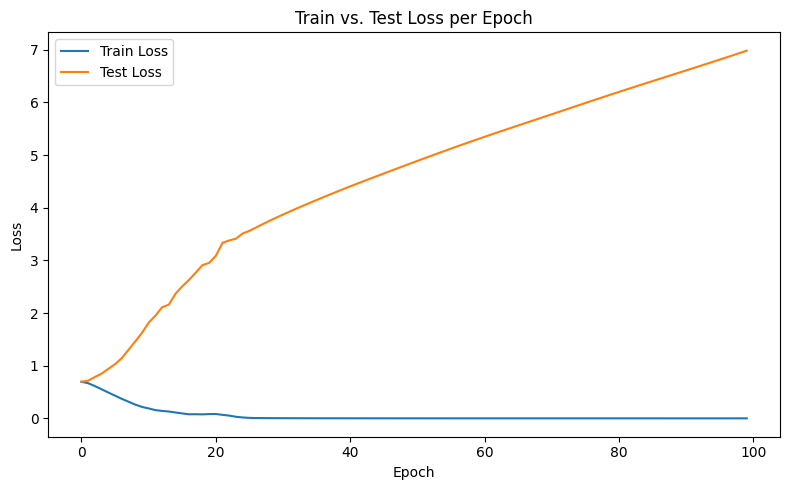

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6264
[Epoch 10/100]  Train Loss: 0.5168
[Epoch 15/100]  Train Loss: 0.4392
[Epoch 20/100]  Train Loss: 0.3900
[Epoch 25/100]  Train Loss: 0.3594
[Epoch 30/100]  Train Loss: 0.3316
[Epoch 35/100]  Train Loss: 0.3159
[Epoch 40/100]  Train Loss: 0.3030
[Epoch 45/100]  Train Loss: 0.2877
[Epoch 50/100]  Train Loss: 0.2751
[Epoch 55/100]  Train Loss: 0.2704
[Epoch 60/100]  Train Loss: 0.2662
[Epoch 65/100]  Train Loss: 0.2530
[Epoch 70/100]  Train Loss: 0.2468
[Epoch 75/100]  Train Loss: 0.2420
[Epoch 80/100]  Train Loss: 0.2485
[Epoch 85/100]  Train Loss: 0.2352
[Epoch 90/100]  Train Loss: 0.2287
[Epoch 95/100]  Train Loss: 0.2318
[Epoch 100/100]  Train Loss: 0.2186
Accuracy on Nonzero Predictions: 0.5200


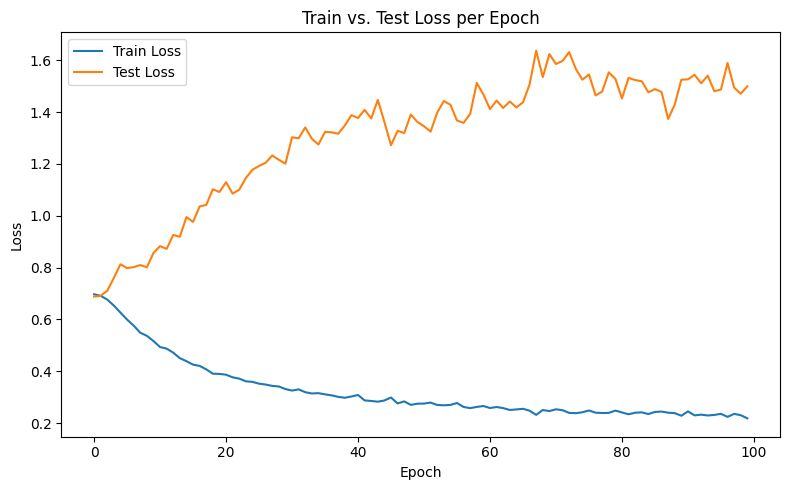

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6276
[Epoch 10/100]  Train Loss: 0.5189
[Epoch 15/100]  Train Loss: 0.4422
[Epoch 20/100]  Train Loss: 0.3862
[Epoch 25/100]  Train Loss: 0.3506
[Epoch 30/100]  Train Loss: 0.3281
[Epoch 35/100]  Train Loss: 0.3159
[Epoch 40/100]  Train Loss: 0.2922
[Epoch 45/100]  Train Loss: 0.2910
[Epoch 50/100]  Train Loss: 0.2850
[Epoch 55/100]  Train Loss: 0.2648
[Epoch 60/100]  Train Loss: 0.2650
[Epoch 65/100]  Train Loss: 0.2577
[Epoch 70/100]  Train Loss: 0.2564
[Epoch 75/100]  Train Loss: 0.2393
[Epoch 80/100]  Train Loss: 0.2480
[Epoch 85/100]  Train Loss: 0.2424
[Epoch 90/100]  Train Loss: 0.2344
[Epoch 95/100]  Train Loss: 0.2425
[Epoch 100/100]  Train Loss: 0.2273
Accuracy on Nonzero Predictions: 0.4833


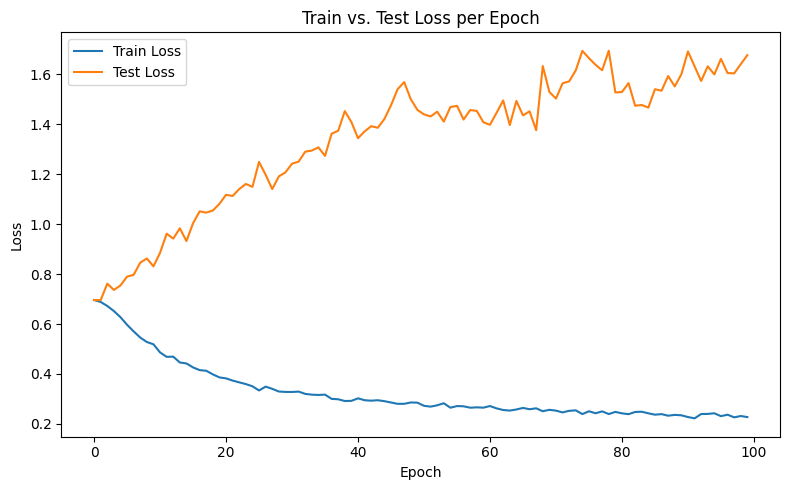

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6318
[Epoch 10/100]  Train Loss: 0.5190
[Epoch 15/100]  Train Loss: 0.4450
[Epoch 20/100]  Train Loss: 0.3875
[Epoch 25/100]  Train Loss: 0.3570
[Epoch 30/100]  Train Loss: 0.3323
[Epoch 35/100]  Train Loss: 0.3064
[Epoch 40/100]  Train Loss: 0.2940
[Epoch 45/100]  Train Loss: 0.2849
[Epoch 50/100]  Train Loss: 0.2843
[Epoch 55/100]  Train Loss: 0.2678
[Epoch 60/100]  Train Loss: 0.2519
[Epoch 65/100]  Train Loss: 0.2532
[Epoch 70/100]  Train Loss: 0.2612
[Epoch 75/100]  Train Loss: 0.2457
[Epoch 80/100]  Train Loss: 0.2331
[Epoch 85/100]  Train Loss: 0.2453
[Epoch 90/100]  Train Loss: 0.2400
[Epoch 95/100]  Train Loss: 0.2326
[Epoch 100/100]  Train Loss: 0.2283
Accuracy on Nonzero Predictions: 0.4900


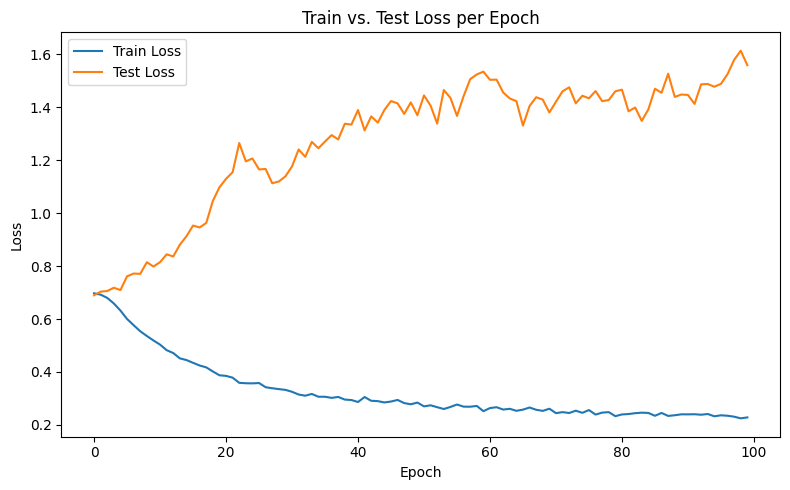

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6277
[Epoch 10/100]  Train Loss: 0.5097
[Epoch 15/100]  Train Loss: 0.4343
[Epoch 20/100]  Train Loss: 0.3875
[Epoch 25/100]  Train Loss: 0.3524
[Epoch 30/100]  Train Loss: 0.3264
[Epoch 35/100]  Train Loss: 0.3089
[Epoch 40/100]  Train Loss: 0.2909
[Epoch 45/100]  Train Loss: 0.2791
[Epoch 50/100]  Train Loss: 0.2724
[Epoch 55/100]  Train Loss: 0.2711
[Epoch 60/100]  Train Loss: 0.2546
[Epoch 65/100]  Train Loss: 0.2558
[Epoch 70/100]  Train Loss: 0.2436
[Epoch 75/100]  Train Loss: 0.2446
[Epoch 80/100]  Train Loss: 0.2389
[Epoch 85/100]  Train Loss: 0.2355
[Epoch 90/100]  Train Loss: 0.2300
[Epoch 95/100]  Train Loss: 0.2307
[Epoch 100/100]  Train Loss: 0.2195
Accuracy on Nonzero Predictions: 0.5200


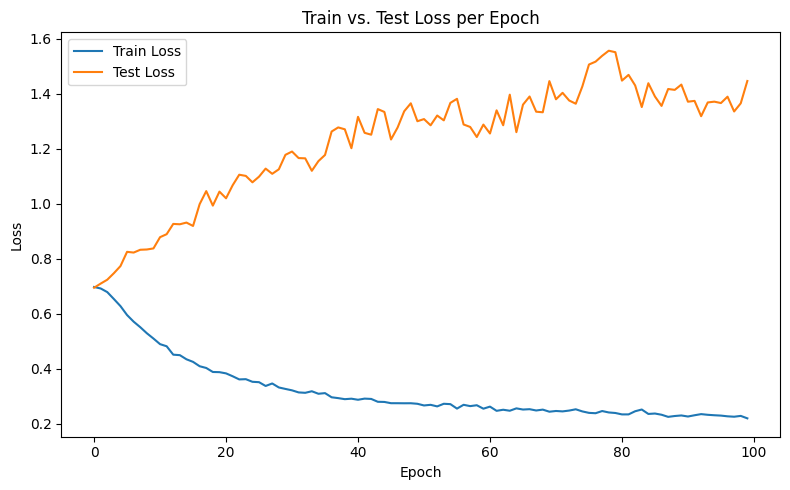

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.6310
[Epoch 10/100]  Train Loss: 0.5185
[Epoch 15/100]  Train Loss: 0.4381
[Epoch 20/100]  Train Loss: 0.4016
[Epoch 25/100]  Train Loss: 0.3517
[Epoch 30/100]  Train Loss: 0.3408
[Epoch 35/100]  Train Loss: 0.3165
[Epoch 40/100]  Train Loss: 0.3020
[Epoch 45/100]  Train Loss: 0.2907
[Epoch 50/100]  Train Loss: 0.2801
[Epoch 55/100]  Train Loss: 0.2634
[Epoch 60/100]  Train Loss: 0.2653
[Epoch 65/100]  Train Loss: 0.2480
[Epoch 70/100]  Train Loss: 0.2494
[Epoch 75/100]  Train Loss: 0.2501
[Epoch 80/100]  Train Loss: 0.2548
[Epoch 85/100]  Train Loss: 0.2510
[Epoch 90/100]  Train Loss: 0.2375
[Epoch 95/100]  Train Loss: 0.2333
[Epoch 100/100]  Train Loss: 0.2326
Accuracy on Nonzero Predictions: 0.5133


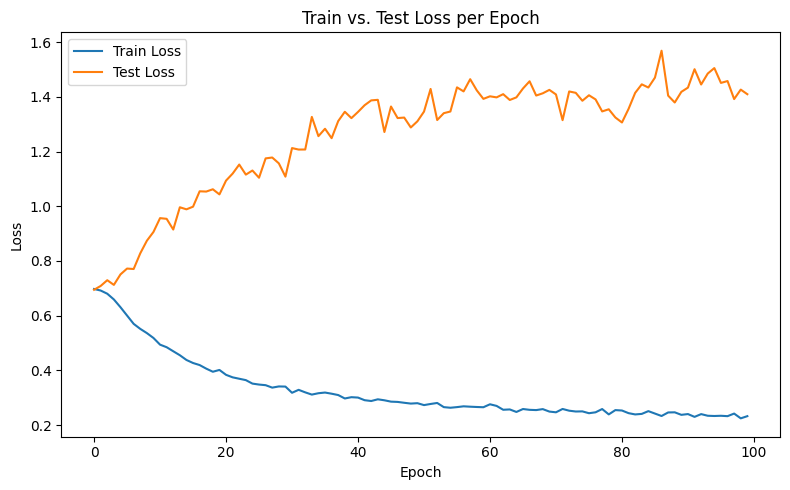

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
----- Appending stock: AAPL, period: 10y, data_type: single_name -----
----- Appending stock: MSFT, period: 10y, data_type: single_name -----
----- Appending stock: AMZN, period: 10y, data_type: single_name -----
----- Appending stock: NVDA, period: 10y, data_type: single_name -----
----- Appending stock: SPX, period: 10y, data_type: single_name -----
Final X shape: (11355, 1, 100)
Final y shape: (11355,)
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.2456
[Epoch 10/100]  Train Loss: 0.0594
[Epoch 15/100]  Train Loss: 0.0102
[Epoch 20/100]  Train Loss: 0.0013
[Epoch 25/100]  Train Loss: 0.0006
[Epoch 30/100]  Train Loss: 0.0003
[Epoch 35/100]  Train Loss: 0.0002
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train 

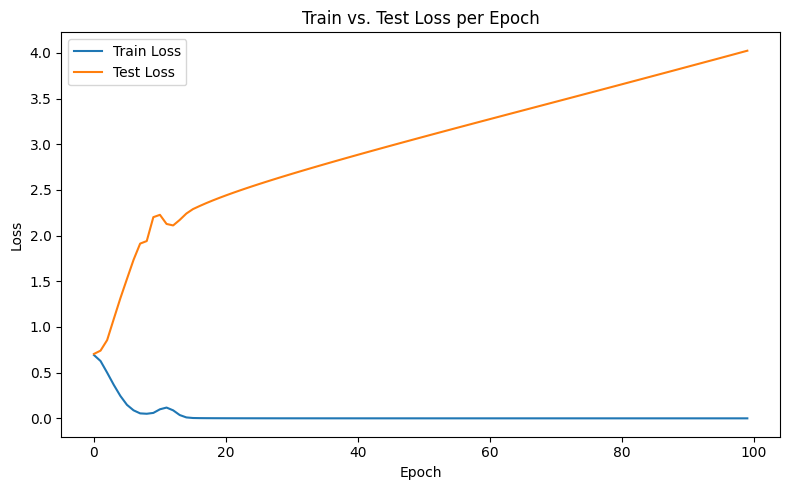

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.2677
[Epoch 10/100]  Train Loss: 0.0638
[Epoch 15/100]  Train Loss: 0.0127
[Epoch 20/100]  Train Loss: 0.0012
[Epoch 25/100]  Train Loss: 0.0006
[Epoch 30/100]  Train Loss: 0.0003
[Epoch 35/100]  Train Loss: 0.0002
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5133


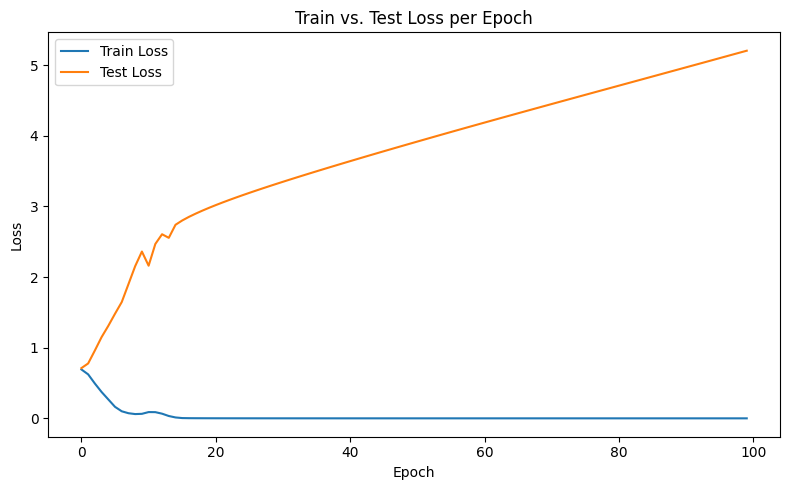

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.2459
[Epoch 10/100]  Train Loss: 0.0085
[Epoch 15/100]  Train Loss: 0.0016
[Epoch 20/100]  Train Loss: 0.0008
[Epoch 25/100]  Train Loss: 0.0004
[Epoch 30/100]  Train Loss: 0.0002
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5167


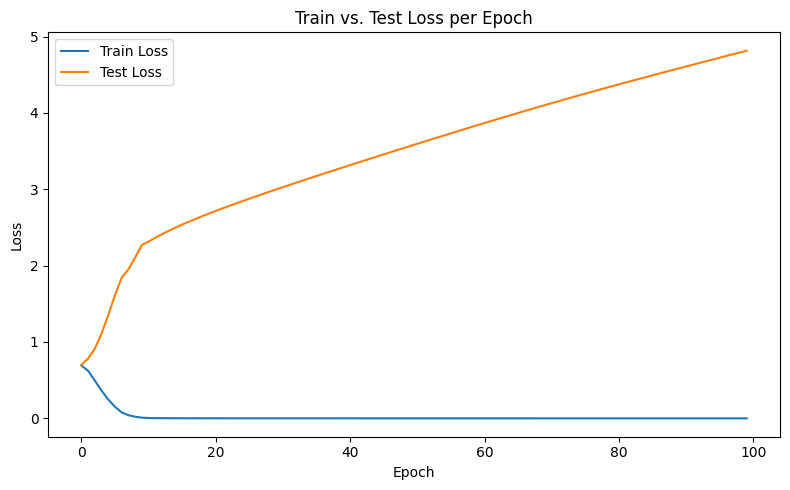

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.2570
[Epoch 10/100]  Train Loss: 0.0271
[Epoch 15/100]  Train Loss: 0.0017
[Epoch 20/100]  Train Loss: 0.0008
[Epoch 25/100]  Train Loss: 0.0004
[Epoch 30/100]  Train Loss: 0.0002
[Epoch 35/100]  Train Loss: 0.0001
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0000
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.5400


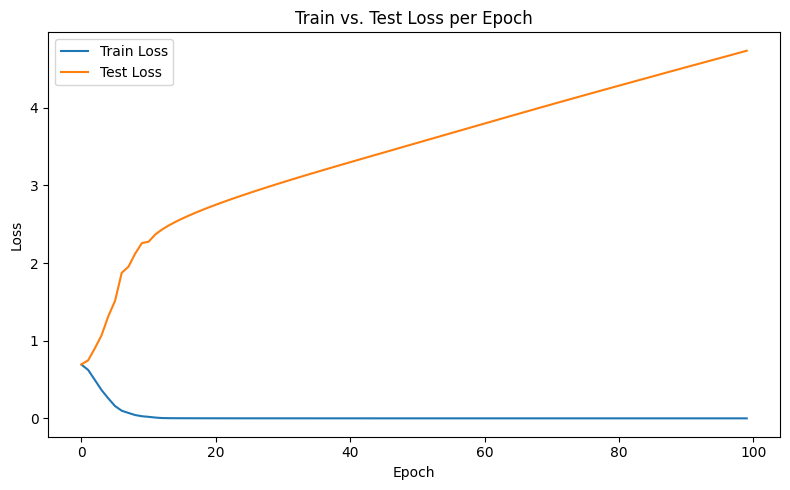

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.2440
[Epoch 10/100]  Train Loss: 0.0402
[Epoch 15/100]  Train Loss: 0.0255
[Epoch 20/100]  Train Loss: 0.0015
[Epoch 25/100]  Train Loss: 0.0007
[Epoch 30/100]  Train Loss: 0.0004
[Epoch 35/100]  Train Loss: 0.0002
[Epoch 40/100]  Train Loss: 0.0001
[Epoch 45/100]  Train Loss: 0.0001
[Epoch 50/100]  Train Loss: 0.0001
[Epoch 55/100]  Train Loss: 0.0000
[Epoch 60/100]  Train Loss: 0.0000
[Epoch 65/100]  Train Loss: 0.0000
[Epoch 70/100]  Train Loss: 0.0000
[Epoch 75/100]  Train Loss: 0.0000
[Epoch 80/100]  Train Loss: 0.0000
[Epoch 85/100]  Train Loss: 0.0000
[Epoch 90/100]  Train Loss: 0.0000
[Epoch 95/100]  Train Loss: 0.0000
[Epoch 100/100]  Train Loss: 0.0000
Accuracy on Nonzero Predictions: 0.4967


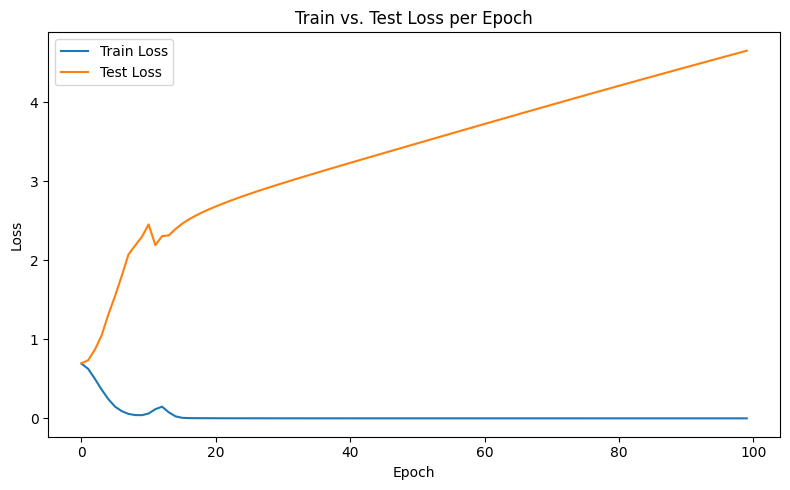

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.5519
[Epoch 10/100]  Train Loss: 0.3893
[Epoch 15/100]  Train Loss: 0.2894
[Epoch 20/100]  Train Loss: 0.2286
[Epoch 25/100]  Train Loss: 0.2115
[Epoch 30/100]  Train Loss: 0.1830
[Epoch 35/100]  Train Loss: 0.1739
[Epoch 40/100]  Train Loss: 0.1532
[Epoch 45/100]  Train Loss: 0.1533
[Epoch 50/100]  Train Loss: 0.1388
[Epoch 55/100]  Train Loss: 0.1430
[Epoch 60/100]  Train Loss: 0.1365
[Epoch 65/100]  Train Loss: 0.1291
[Epoch 70/100]  Train Loss: 0.1175
[Epoch 75/100]  Train Loss: 0.1184
[Epoch 80/100]  Train Loss: 0.1171
[Epoch 85/100]  Train Loss: 0.1239
[Epoch 90/100]  Train Loss: 0.1145
[Epoch 95/100]  Train Loss: 0.1144
[Epoch 100/100]  Train Loss: 0.1110
Accuracy on Nonzero Predictions: 0.5067


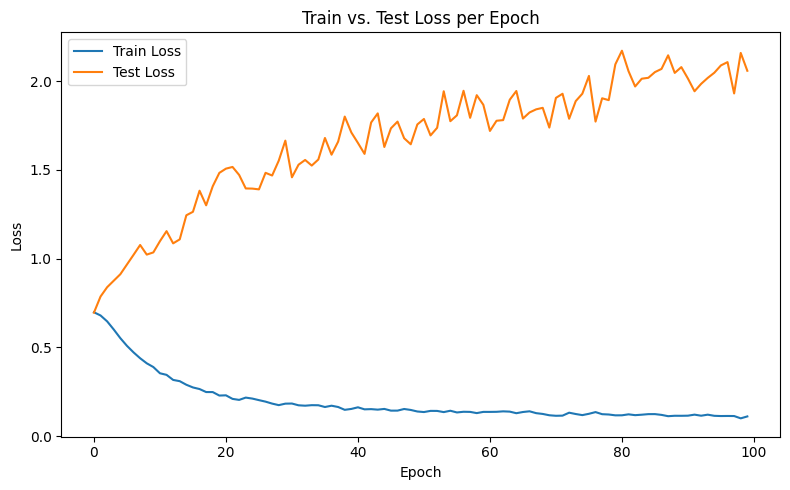

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.5445
[Epoch 10/100]  Train Loss: 0.3784
[Epoch 15/100]  Train Loss: 0.2834
[Epoch 20/100]  Train Loss: 0.2405
[Epoch 25/100]  Train Loss: 0.2015
[Epoch 30/100]  Train Loss: 0.1860
[Epoch 35/100]  Train Loss: 0.1668
[Epoch 40/100]  Train Loss: 0.1558
[Epoch 45/100]  Train Loss: 0.1524
[Epoch 50/100]  Train Loss: 0.1471
[Epoch 55/100]  Train Loss: 0.1394
[Epoch 60/100]  Train Loss: 0.1308
[Epoch 65/100]  Train Loss: 0.1322
[Epoch 70/100]  Train Loss: 0.1310
[Epoch 75/100]  Train Loss: 0.1157
[Epoch 80/100]  Train Loss: 0.1110
[Epoch 85/100]  Train Loss: 0.1277
[Epoch 90/100]  Train Loss: 0.1201
[Epoch 95/100]  Train Loss: 0.1108
[Epoch 100/100]  Train Loss: 0.1110
Accuracy on Nonzero Predictions: 0.5533


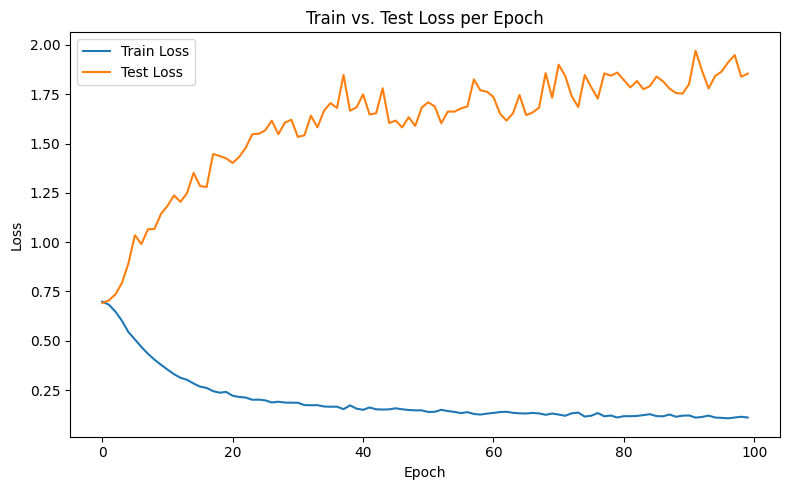

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.5540
[Epoch 10/100]  Train Loss: 0.3750
[Epoch 15/100]  Train Loss: 0.2871
[Epoch 20/100]  Train Loss: 0.2456
[Epoch 25/100]  Train Loss: 0.1927
[Epoch 30/100]  Train Loss: 0.1903
[Epoch 35/100]  Train Loss: 0.1866
[Epoch 40/100]  Train Loss: 0.1606
[Epoch 45/100]  Train Loss: 0.1654
[Epoch 50/100]  Train Loss: 0.1448
[Epoch 55/100]  Train Loss: 0.1393
[Epoch 60/100]  Train Loss: 0.1394
[Epoch 65/100]  Train Loss: 0.1334
[Epoch 70/100]  Train Loss: 0.1299
[Epoch 75/100]  Train Loss: 0.1235
[Epoch 80/100]  Train Loss: 0.1217
[Epoch 85/100]  Train Loss: 0.1175
[Epoch 90/100]  Train Loss: 0.1146
[Epoch 95/100]  Train Loss: 0.1138
[Epoch 100/100]  Train Loss: 0.1074
Accuracy on Nonzero Predictions: 0.5233


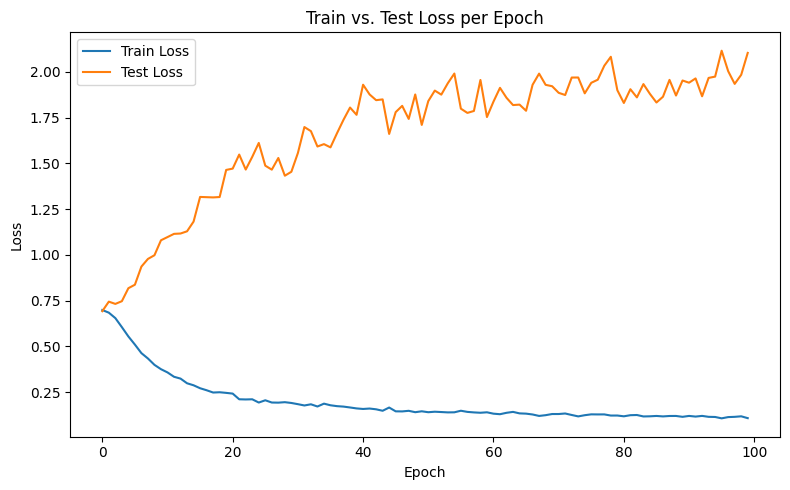

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.5612
[Epoch 10/100]  Train Loss: 0.3855
[Epoch 15/100]  Train Loss: 0.2902
[Epoch 20/100]  Train Loss: 0.2386
[Epoch 25/100]  Train Loss: 0.2119
[Epoch 30/100]  Train Loss: 0.1824
[Epoch 35/100]  Train Loss: 0.1681
[Epoch 40/100]  Train Loss: 0.1608
[Epoch 45/100]  Train Loss: 0.1578
[Epoch 50/100]  Train Loss: 0.1497
[Epoch 55/100]  Train Loss: 0.1344
[Epoch 60/100]  Train Loss: 0.1276
[Epoch 65/100]  Train Loss: 0.1230
[Epoch 70/100]  Train Loss: 0.1260
[Epoch 75/100]  Train Loss: 0.1206
[Epoch 80/100]  Train Loss: 0.1142
[Epoch 85/100]  Train Loss: 0.1108
[Epoch 90/100]  Train Loss: 0.1084
[Epoch 95/100]  Train Loss: 0.1163
[Epoch 100/100]  Train Loss: 0.1093
Accuracy on Nonzero Predictions: 0.5167


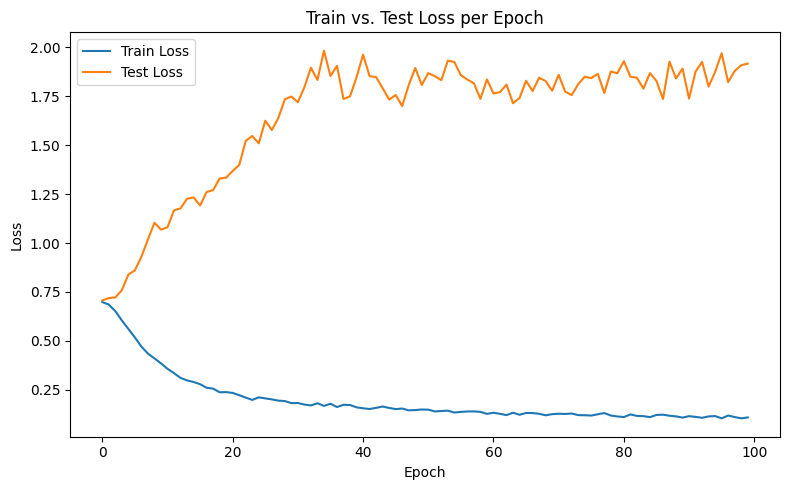

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png
Training SPX | LR: 0.01 | Epochs: 100 | Batch: 64 | Security type: single_name
[Epoch 5/100]  Train Loss: 0.5511
[Epoch 10/100]  Train Loss: 0.3774
[Epoch 15/100]  Train Loss: 0.2825
[Epoch 20/100]  Train Loss: 0.2444
[Epoch 25/100]  Train Loss: 0.1904
[Epoch 30/100]  Train Loss: 0.1804
[Epoch 35/100]  Train Loss: 0.1678
[Epoch 40/100]  Train Loss: 0.1632
[Epoch 45/100]  Train Loss: 0.1537
[Epoch 50/100]  Train Loss: 0.1488
[Epoch 55/100]  Train Loss: 0.1405
[Epoch 60/100]  Train Loss: 0.1367
[Epoch 65/100]  Train Loss: 0.1268
[Epoch 70/100]  Train Loss: 0.1266
[Epoch 75/100]  Train Loss: 0.1155
[Epoch 80/100]  Train Loss: 0.1238
[Epoch 85/100]  Train Loss: 0.1110
[Epoch 90/100]  Train Loss: 0.1054
[Epoch 95/100]  Train Loss: 0.1149
[Epoch 100/100]  Train Loss: 0.1130
Accuracy on Nonzero Predictions: 0.5133


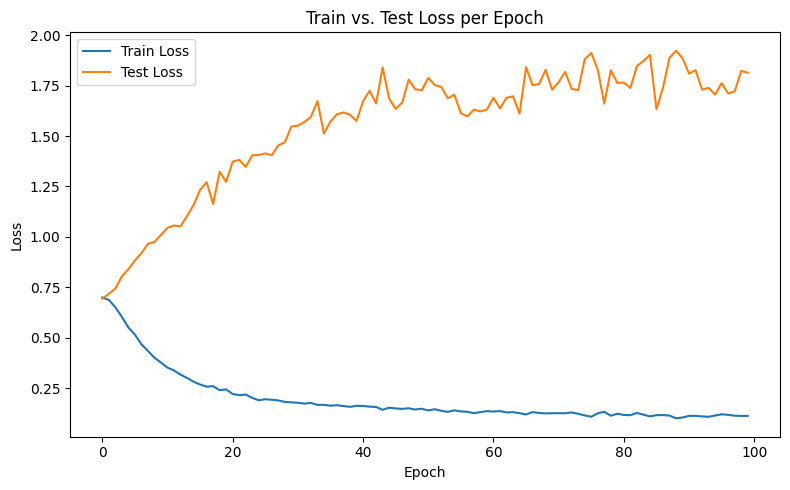

Loss curves saved to: /home/jupyter-tfg2425paula/prediction_project_v3/03_plots/train_test_loss_curve.png


In [15]:
# train_size = X_combined.shape[0]-30
security_type = "single_name"
model_types = ["lstm", "gru"]   
sample_size = 5
window_sizes = [5, 10, 50, 100]
stocks = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'SPX']
test_size = 300

results_list = []

for window_size in window_sizes:
    X_combined, y_combined = combine_stocks_pkl_new_df(processing, security_type, period, window_size, project_dir, stocks, test_size)
    input_size = X_combined.shape[2]
    # train_size = int(X_combined.shape[0] * possible_train_size / 100)
    train_size = X_combined.shape[0] - test_size
    # test_size = X_combined.shape[0] - train_size
    for model_type in model_types:
        for i in range(sample_size):
            if model_type == "gru":
                model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
            elif model_type == "lstm":
                model = StockPriceLSTM(input_size, hidden_size, output_size)

            model = model.to(device)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            print(f"Training {stocks[-1]} | LR: {learning_rate} | Epochs: {num_epochs} "
                  f"| Batch: {batch_size} | Security type: {security_type}")


            result = evaluate_model_plot(
                model, 
                X_combined, 
                y_combined, 
                criterion, 
                optimizer, 
                device, 
                train_size, 
                batch_size, 
                num_epochs, 
                lower_threshold = 0.5,
                plots_dir=plots_dir,
                plot_filename=None
            )

            # Store results in a list
            results_list.append({
                "security_type": security_type,
                "window_size": window_size,
                "model_type": model_type,
                "iteration": i + 1,
                "accuracy_nonzero": result["accuracy_nonzero"],
                "loss_decrease_percentage": result["loss_decrease_percentage"],
                "final_train_loss": result["final_train_loss"]
            })

results_df = pd.DataFrame(results_list)

In [16]:
results_df

,security_type,window_size,model_type,iteration,accuracy_nonzero,loss_decrease_percentage,final_train_loss
0,single_name,5,lstm,1,0.516667,-3.520939,6.704099e-01
1,single_name,5,lstm,2,0.503333,-3.507834,6.705212e-01
2,single_name,5,lstm,3,0.516667,-4.551124,6.632414e-01
3,single_name,5,lstm,4,0.493333,-4.230083,6.653267e-01
4,single_name,5,lstm,5,0.573333,-3.112409,6.734595e-01
5,single_name,5,gru,1,0.546667,-4.799587,6.620721e-01
6,single_name,5,gru,2,0.530000,-4.331017,6.651364e-01
7,single_name,5,gru,3,0.543333,-4.670197,6.624775e-01
8,single_name,5,gru,4,0.513333,-5.527830,6.564860e-01
9,single_name,5,gru,5,0.536667,-3.448694,6.712404e-01


In [17]:
output_folder = os.path.join(results_dir, 'combined_vs_individual_v1')

results_df.to_csv(os.path.join(output_folder, f'combined_single_name.csv'), index=False)